<a href="https://colab.research.google.com/github/CUSPADS2022IBX/IBXRidership/blob/main/PLUTO_cleaning_final_forreal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#re run the whole thing 

### PLUTO Cleaning

#### Packages & Libraries

In [ ]:
#push IBX one 

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6edb97705aafce3ad3481855786234c548dc41358f5c2b338dcb598b8c358e54
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
!pip install geopandas


     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 16.7 MB 40.6 MB/s 
     |████████████████████████████████| 6.3 MB 33.1 MB/s 


In [3]:
!pip install pyspark
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas


     |████████████████████████████████| 281.4 MB 22 kB/s 
     |████████████████████████████████| 198 kB 59.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=8617a217dc8b0ccd11e96d18d1a6d4ff8147c4304f8ad355459f1a5074253dd1
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 1.0 MB 6.8 MB/s 


In [4]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import IPython
import wget
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
import zipfile

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark

#### Reading in PLUTO .csv directly from zip URL

In [5]:
#downloading
!wget 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_21v4_csv.zip'
!unzip 'nyc_pluto_21v4_csv.zip'

--2022-05-03 16:49:33--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_21v4_csv.zip
Resolving www1.nyc.gov (www1.nyc.gov)... 104.90.112.221, 2600:1406:3c:383::1500, 2600:1406:3c:38e::1500
Connecting to www1.nyc.gov (www1.nyc.gov)|104.90.112.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93698884 (89M) [application/zip]
Saving to: ‘nyc_pluto_21v4_csv.zip’

nyc_pluto_21v4_csv. 100%[===================>]  89.36M  81.0MB/s    in 1.1s    

2022-05-03 16:49:34 (81.0 MB/s) - ‘nyc_pluto_21v4_csv.zip’ saved [93698884/93698884]

Archive:  nyc_pluto_21v4_csv.zip
  inflating: PLUTODD21v4.pdf         
  inflating: PlutoReadme21v4.pdf     
  inflating: pluto_21v4.csv          


In [6]:
#reading as spark dataframe 
pluto = spark.read.csv('/content/pluto_21v4.csv',header=True)\
.select('BCT2020','lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea','numbldgs','numfloors','unitsres','unitstotal','assesstot')


In [7]:
#list of column names for iterating 
cols = pluto.columns[1:]

#iterating through spark DF columns to cast to float 
for col_name in cols:
    pluto = pluto.withColumn(col_name, F.col(col_name).cast('float'))

#sums of counts as groupby
pluto_tract = pluto.groupBy('BCT2020').sum()

#list of column names for iterating
cols1 = pluto_tract.columns[1:]

for i in range(len(cols1)):
    pluto_tract = pluto_tract.withColumnRenamed(cols1[i],cols[i])

In [8]:
pluto_tract.show(5)


#aggregated by station 

+-------+---------+---------+--------+---------+----------+----------+----------+---------+----------+---------+--------+------------------+--------+----------+------------+
|BCT2020|  lotarea| bldgarea| comarea|  resarea|officearea|retailarea|garagearea|strgearea|factryarea|otherarea|numbldgs|         numfloors|unitsres|unitstotal|   assesstot|
+-------+---------+---------+--------+---------+----------+----------+----------+---------+----------+---------+--------+------------------+--------+----------+------------+
|3056600|1258182.0|1254905.0|196353.0| 978845.0|   82590.0|   69635.0|    5550.0|      0.0|       0.0|  38578.0|   575.0|             762.0|   988.0|    1032.0| 5.2304088E7|
|4072300|3602899.0|1899353.0|125662.0|1756701.0|    6791.0|    8100.0|       0.0|      0.0|       0.0| 110771.0|  1045.0|1574.5899999141693|   913.0|     934.0|  9.459345E7|
|4027200|1194838.0| 644470.0| 99013.0| 538597.0|    8594.0|   49467.0|       0.0|   2550.0|       0.0|  36853.0|   617.0| 954.6699

In [ ]:
#could group by census block (~350,169) different groups 
#could aggregate by census tract (~5,000)
#could aggregate by zip (~1700)
#could aggregate by tax lots or tax blocks 

2323

In [9]:
pluto_df = pluto_tract.toPandas()
pluto_df.head()

BCT2020    lotarea   bldgarea   comarea    resarea  officearea  retailarea  \
0  3056600  1258182.0  1254905.0  196353.0   978845.0     82590.0     69635.0   
1  4072300  3602899.0  1899353.0  125662.0  1756701.0      6791.0      8100.0   
2  4027200  1194838.0   644470.0   99013.0   538597.0      8594.0     49467.0   
3  3080200  1428334.0  2334285.0  300431.0  1947838.0     13892.0     93475.0   
4  2033700  2948047.0  1887595.0  370078.0  1400446.0    128057.0     66977.0   

   garagearea  strgearea  factryarea  otherarea  numbldgs  numfloors  \
0      5550.0        0.0         0.0    38578.0     575.0     762.00   
1         0.0        0.0         0.0   110771.0    1045.0    1574.59   
2         0.0     2550.0         0.0    36853.0     617.0     954.67   
3      1215.0        0.0         0.0   191849.0     464.0    1096.43   
4     36040.0     1041.0         0.0   136467.0     663.0    1254.76   

   unitsres  unitstotal    assesstot  
0     988.0      1032.0   52304088.0  
1     913.0       934.0   94593450.0  
2     550.0       595.0   21781104.0  
3    1924.0      2041.0  103270263.0  
4    1256.0      1352.0   66661442.0

#### Census Data Merge

In [10]:
import geopandas as gpd

In [11]:
#getting census data 
!wget 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2020_22a.zip'
!unzip 'nyct2020_22a.zip'



--2022-05-03 16:50:32--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2020_22a.zip
Resolving www1.nyc.gov (www1.nyc.gov)... 104.90.112.221, 2600:1406:3c:383::1500, 2600:1406:3c:38e::1500
Connecting to www1.nyc.gov (www1.nyc.gov)|104.90.112.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472942 (1.4M) [application/zip]
Saving to: ‘nyct2020_22a.zip’

nyct2020_22a.zip    100%[===================>]   1.40M  --.-KB/s    in 0.05s   

2022-05-03 16:50:32 (26.3 MB/s) - ‘nyct2020_22a.zip’ saved [1472942/1472942]

Archive:  nyct2020_22a.zip
  inflating: nyct2020_22a/nyct2020.shp  
  inflating: nyct2020_22a/nyct2020.dbf  
  inflating: nyct2020_22a/nyct2020.shx  
  inflating: nyct2020_22a/nyct2020.prj  
  inflating: nyct2020_22a/nyct2020.shp.xml  


In [12]:
#read in shapefile for later merge 
census_geo = gpd.read_file('/content/nyct2020_22a/nyct2020.dbf')

census_geo.shape


(2325, 14)

In [13]:
#read in ACS census data from git 
census_data = pd.read_csv('https://raw.githubusercontent.com/CUSPADS2022IBX/IBXRidership/main/PLUTO%20Data%20Processing/census_tract_data_nyc.csv')

In [14]:
#merge pluto with census data 
pluto_census = pluto_df.merge(census_data.drop_duplicates('BCT2020'),left_on='BCT2020',right_on='BCT2020', how = 'left')
pluto_census.shape

(2323, 51)

In [15]:
#cleaning census columns from objects to float 
#remove commas
pluto_census = pluto_census.replace(',','', regex=True)

#fill nas with 0s 

In [16]:
#convert to float
cols = pluto_census.columns.drop(['BCT2020','Name', 'CD Type', 'NTA Type'])

pluto_census[cols] = pluto_census[cols].apply(pd.to_numeric, errors='coerce')

In [17]:
#drop weird last column
pluto_census = pluto_census.iloc[:,:-1]



(2323, 50)

In [20]:
#merge with census geometry
pluto_geo = pluto_census.merge(census_geo,left_on='BCT2020',right_on='BoroCT2020',how='left')
pluto_geo.shape

(2323, 64)

BCT2020      lotarea   bldgarea    comarea    resarea  officearea  \
0     3056600    1258182.0  1254905.0   196353.0   978845.0     82590.0   
1     4072300    3602899.0  1899353.0   125662.0  1756701.0      6791.0   
2     4027200    1194838.0   644470.0    99013.0   538597.0      8594.0   
3     3080200    1428334.0  2334285.0   300431.0  1947838.0     13892.0   
4     2033700    2948047.0  1887595.0   370078.0  1400446.0    128057.0   
...       ...          ...        ...        ...        ...         ...   
2318  1000500    7736692.0  2598091.0  2598091.0        0.0         0.0   
2319  1000100    3306076.0  1145016.0  1145016.0        0.0         0.0   
2320  3015400   10490000.0    16570.0    16570.0        0.0         0.0   
2321  1023802     490397.0   661538.0   661538.0        0.0         0.0   
2322  3070203  207391232.0        0.0        NaN        NaN         NaN   

      retailarea  garagearea  strgearea  factryarea  ...  other_num  \
0        69635.0      5550.0        0.0         0.0  ...         20   
1         8100.0         0.0        0.0         0.0  ...         21   
2        49467.0         0.0     2550.0         0.0  ...        138   
3        93475.0      1215.0        0.0         0.0  ...         59   
4        66977.0     36040.0     1041.0         0.0  ...         70   
...          ...         ...        ...         ...  ...        ...   
2318         0.0         0.0        0.0         0.0  ...          0   
2319         0.0         0.0        0.0         0.0  ...          0   
2320         0.0         0.0        0.0         0.0  ...          1   
2321         0.0         0.0        0.0         0.0  ...        223   
2322         NaN         NaN        NaN         NaN  ...          0   

      other_perc  multirace_num  multirace_perc  total_houses  \
0            0.8             91             3.6         1,049   
1            1.0             99             4.6           858   
2            6.7            156             7.6           615   
3            1.3            320             7.1         1,999   
4            1.8            207             5.4         1,288   
...          ...            ...             ...           ...   
2318         NaN              2            40.0            25   
2319         NaN              0             NaN             0   
2320        11.1              3            33.3             1   
2321         4.7            211             4.4         1,983   
2322         NaN              0             NaN             0   

      occupied_homes_num occupied_homes_perc vacant_homes_num  \
0                    990                94.4               59   
1                    799                93.1               59   
2                    591                96.1               24   
3                  1,881                94.1              118   
4                  1,182                91.8              106   
...                  ...                 ...              ...   
2318                   0                 NaN               25   
2319                   0                 NaN                0   
2320                   0                 NaN                1   
2321               1,802                90.9              181   
2322                   0                 NaN                0   

     vacant_homes_perc Unnamed: 35  
0                  5.6         NaN  
1                  6.9         NaN  
2                  3.9         NaN  
3                  5.9         NaN  
4                  8.2         NaN  
...                ...         ...  
2318             100.0         NaN  
2319               NaN         NaN  
2320             100.0         NaN  
2321               9.1         NaN  
2322               NaN         NaN  

[2323 rows x 51 columns]

In [21]:
#creating geodf 
pluto_gdf = gpd.GeoDataFrame(
    pluto_geo, geometry=pluto_geo['geometry'],crs=census_geo.crs)

#### Employment Merge

In [ ]:
#try to read in census data with employment merge on BCT or GEOID to get labor stats, re run rest, dont normalize 

In [22]:
#read in employment estimate 
employment = pd.read_csv('https://raw.githubusercontent.com/CUSPADS2022IBX/IBXRidership/main/PLUTO%20Data%20Processing/employment.csv');employment.head(3)

Employment_est                GEO_ID  \
0            6600  1400000US36005000100   
1            3305  1400000US36005000200   
2            4946  1400000US36005000400   

                                     NAME  
0  Census Tract 1, Bronx County, New York  
1  Census Tract 2, Bronx County, New York  
2  Census Tract 4, Bronx County, New York

In [23]:
#drop name columns 
employment = employment.drop(['NAME'],axis=1)

In [24]:
#get rid of 1400000US from GEO_ID column
employment['GEOID'] = employment['GEO_ID'].replace('1400000US','',regex=True)

In [24]:
employment

Employment_est                GEO_ID           GEOID
0               6600  1400000US36005000100     36005000100
1               3305  1400000US36005000200     36005000200
2               4946  1400000US36005000400     36005000400
3               4814  1400000US36005001600     36005001600
4               1490  1400000US36005001901     36005001901
...              ...                   ...             ...
2327         1111242        0500000US36005  0500000US36005
2328         2046251        0500000US36047  0500000US36047
2329         1418173        0500000US36061  0500000US36061
2330         1862239        0500000US36081  0500000US36081
2331          383886        0500000US36085  0500000US36085

[2332 rows x 3 columns]

In [25]:
#merge with census and pluto data 
pluto_gdf = pluto_gdf.merge(employment,on='GEOID',how='left').drop(['GEO_ID'],axis=1)

#### Station Voronois

In [26]:
import pandas as pd

In [27]:
#read in stations with IBX
stations = pd.read_csv('https://raw.githubusercontent.com/CUSPADS2022IBX/IBXRidership/main/Network%20Processing/station_complex_nodes.csv'); stations

Unnamed: 0 station_id station_line        lat Complex ID  \
0          1530        G26      station  40.731352        283   
1          1531        G24      station  40.744065        282   
2          1533        G20      station  40.752039        272   
3          1534        G21      station  40.748973        273   
4          1535        G28      station  40.724635        284   
..          ...        ...          ...        ...        ...   
428        2044    complex      complex  40.702249        635   
429        2045    complex      complex  40.692259        636   
430        2046    complex      complex  40.732338        167   
431        2047    complex      complex  40.824783        151   
432        2048    complex      complex  40.713154        622   

                            name    lines boro       long    line_      dir  \
0                  Greenpoint Av      NaN   Bk -73.954449        G  station   
1                          21 St      NaN    Q -73.949724        G  station   
2                          36 St      NaN    Q -73.928781      M R  station   
3                   Queens Plaza      NaN    Q -73.937243    E M R  station   
4                      Nassau Av      NaN   Bk -73.951277        G  station   
..                           ...      ...  ...        ...      ...      ...   
428             South Ferry Loop  complex    M -74.013100  complex  complex   
429           Jay St - MetroTech  complex   Bk -73.986642  complex  complex   
430                       W 4 St  complex    M -74.000495  complex  complex   
431                       145 St  complex    M -73.944216  complex  complex   
432  Brooklyn Bridge - City Hall  complex    M -74.003766  complex  complex   

       pf_id node_id  
0    station     G26  
1    station     G24  
2    station     G20  
3    station     G21  
4    station     G28  
..       ...     ...  
428  complex    635c  
429  complex    636c  
430  complex    167c  
431  complex    151c  
432  complex    622c  

[433 rows x 13 columns]

In [28]:
#with and without ibx 
stations_now = stations[~stations['station_id'].str.contains('X')]
stations_ibx = stations

In [ ]:
#download borough boundary from:
#https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
#OR https://github.com/CUSPADS2022IBX/IBXRidership/tree/main/PLUTO%20Data%20Processing/Borough%20Boundaries


In [30]:
#getting shapefiles from link directly 
!wget 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
!unzip 'tqmj-j8zm?method=export&format=Shapefile'


--2022-05-03 16:52:19--  https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tqmj-j8zm?method=export&format=Shapefile’

tqmj-j8zm?method=ex     [  <=>               ] 908.97K  2.92MB/s    in 0.3s    

2022-05-03 16:52:20 (2.92 MB/s) - ‘tqmj-j8zm?method=export&format=Shapefile’ saved [930790]

Archive:  tqmj-j8zm?method=export&format=Shapefile
  inflating: geo_export_c1ef2a4a-44b1-49ff-b1a9-a7d736f29a64.dbf  
  inflating: geo_export_c1ef2a4a-44b1-49ff-b1a9-a7d736f29a64.shp  
  inflating: geo_export_c1ef2a4a-44b1-49ff-b1a9-a7d736f29a64.shx  
  inflating: geo_export_c1ef2a4a-44b1-49ff-b1a9-a7d736f29a64.prj  


In [7]:
import geopandas as gpd

In [31]:
#convert to gpd, correct crs
#need to copy file path from content directory
boros = gpd.read_file('geo_export_c1ef2a4a-44b1-49ff-b1a9-a7d736f29a64.shp')

boros


boro_code      boro_name    shape_area     shape_leng  \
0        4.0         Queens  3.040206e+09  900269.280485   
1        3.0       Brooklyn  1.934167e+09  728477.954082   
2        5.0  Staten Island  1.623631e+09  325924.002076   
3        1.0      Manhattan  6.366208e+08  359993.126318   
4        2.0          Bronx  1.187194e+09  463868.599917   

                                            geometry  
0  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...  
1  MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...  
2  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
3  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
4  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...

In [32]:
!pip install contextily
!pip install geovoronoi
!pip install shapely

     |████████████████████████████████| 19.3 MB 1.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [33]:
#imports and install for voronoi
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

In [34]:
#modifying roosevelt island 
#now
stations_now.loc[stations_now['Complex ID']=='222','long'] = -73.952861
stations_now.loc[stations_now['Complex ID']=='222','lat'] = 40.759002

#ibx 
stations_ibx.loc[stations_ibx['Complex ID']=='222','long'] = -73.952861
stations_ibx.loc[stations_ibx['Complex ID']=='222','lat'] = 40.759002

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [35]:
#modifying central broad chennel 
#now
stations_now.loc[stations_now['Complex ID']=='199','long'] = -73.817478
stations_now.loc[stations_now['Complex ID']=='199','lat'] = 40.607879


#ibx
stations_ibx.loc[stations_ibx['Complex ID']=='199','long'] = -73.817478
stations_ibx.loc[stations_ibx['Complex ID']=='199','lat'] = 40.607879



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
stations_ibx.loc[stations_ibx['Complex ID']=='222']

Unnamed: 0 station_id station_line        lat Complex ID  \
240        1815        B06      station  40.759002        222   

                 name lines boro       long line_      dir    pf_id node_id  
240  Roosevelt Island   NaN    M -73.952861     F  station  station     B06

In [36]:
#convert stations to geopandas, matching crs 
stations_now_geo = gpd.GeoDataFrame(stations_now,geometry=gpd.points_from_xy(stations_now.long, stations_now.lat),crs=boros.crs)
stations_ibx_geo = gpd.GeoDataFrame(stations_ibx, geometry=gpd.points_from_xy(stations_ibx.long, stations_ibx.lat),crs=boros.crs)

In [ ]:
#tmp = stations[stations['station_id'].str.contains('X')]
#push roosevelt island to right (east and south a bit ) and central broad channel to left (west) - 200 feet 

In [37]:
#moving around specific stations slightly to incorporate voronois 
#222, 199
stations_now_geo.loc[stations_now_geo['Complex ID'] == '222']


Unnamed: 0 station_id station_line        lat Complex ID  \
240        1815        B06      station  40.759002        222   

                 name lines boro       long line_      dir    pf_id node_id  \
240  Roosevelt Island   NaN    M -73.952861     F  station  station     B06   

                       geometry  
240  POINT (-73.95286 40.75900)

In [38]:
#quick plot with ibx stations in red 
fig, ax = plt.subplots(figsize=(12, 10))
boros.plot(ax=ax)
#plotting stations as is 
stations_now_geo.plot(ax=ax, markersize=3.5, color = 'black')
#getting just ibx and plotting
tmp = stations_ibx_geo[stations_ibx_geo['station_id'].str.contains('X')]
tmp.plot(ax=ax, markersize=3.5, color = 'red')
plt.show()

In [38]:
#trying to get individual polygons to account for islands 
boros_exploded=boros.explode()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  


In [39]:
#now trying to remove indexes?

boros_exploded.reset_index(drop=True, inplace=True)

##### Testing SciPy Voronoi

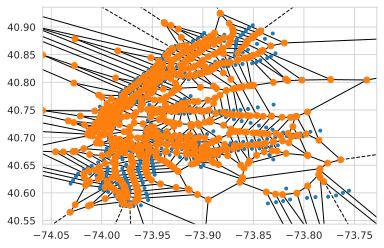

In [ ]:
from scipy.spatial import Voronoi
listarray = []
for pp in stations_now_geo.geometry:
    listarray.append([pp.x, pp.y])
nparray = np.array(listarray)

from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(nparray)

fig = voronoi_plot_2d(vor)
plt.show()

##### Creating Voronois

In [ ]:
from shapely.ops import unary_union

In [41]:
#union for voronoi package
#boros_shape = cascaded_union(boros_exploded.geometry)
boros_shape = unary_union(boros_exploded.geometry)

coords_now = points_to_coords(stations_now_geo.geometry)
coords_ibx = points_to_coords(stations_ibx_geo.geometry)


In [42]:
#get voronois for both
#3 stations on islands... 
poly_shapes_now, pts_now = voronoi_regions_from_coords(coords_now, boros_shape)
poly_shapes_ibx, pts_ibx = voronoi_regions_from_coords(coords_ibx, boros_shape)

In [43]:
len(poly_shapes_now)

421

In [99]:
#voronoi plot 
fig, ax = subplot_for_map(figsize=(12, 10))


plot_voronoi_polys_with_points_in_area(ax, boros_shape, poly_shapes_ibx, coords_ibx, pts_ibx)
plt.show()

/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


In [45]:
#some multipolygons turning into polygon lists
voronoi_regions_now=pd.DataFrame.from_dict(poly_shapes_now,orient='index')
voronoi_regions_ibx=pd.DataFrame.from_dict(poly_shapes_ibx,orient='index')

#convert to geopandas - same crs used for original crs 
voronoi_gpd_now = gpd.GeoDataFrame(voronoi_regions_now, geometry=voronoi_regions_now[0],crs=boros.crs)
voronoi_gpd_ibx = gpd.GeoDataFrame(voronoi_regions_ibx, geometry=voronoi_regions_ibx[0],crs=boros.crs)


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [50]:
#convert voronoi to new york projection, same as pluto_gdf
#voronoi_gpd_now = voronoi_gpd_now.to_crs(crs=pluto_gdf.crs)
#voronoi_gpd_ibx = voronoi_gpd_ibx.to_crs(crs=pluto_gdf.crs)

In [47]:
voronoi_gpd_now = voronoi_gpd_now.to_crs(crs='EPSG:32118')
voronoi_gpd_ibx = voronoi_gpd_ibx.to_crs(crs='EPSG:32118')


In [27]:
#!pip install rtree
#!pip install pygeos
import rtree
#import pygeos

ModuleNotFoundError: ignored

In [50]:
#creating polygon IDs for later grouping from index values 
voronoi_gpd_now = voronoi_gpd_now.reset_index()
voronoi_gpd_ibx = voronoi_gpd_ibx.reset_index()

In [51]:
#rename column 
voronoi_gpd_now = voronoi_gpd_now.rename(columns={"index": "VoroID"})
voronoi_gpd_ibx = voronoi_gpd_ibx.rename(columns={"index": "VoroID"})

In [27]:
voronoi_gpd_now

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.p

VoroID                                                  0  \
0         0  POLYGON ((-73.78508263216672 40.69524093084361...   
1         1  POLYGON ((-73.78508263216672 40.69524093084361...   
2         2  POLYGON ((-73.8215765684226 40.73682683543518,...   
3         3  POLYGON ((-73.80510932606173 40.70367197067032...   
4         4  POLYGON ((-73.81248022095264 40.70124296910148...   
..      ...                                                ...   
416     416  POLYGON ((-73.82302486483574 40.58080877226646...   
417     417  POLYGON ((-73.78287847079686 40.60609019366927...   
418     418  POLYGON ((-73.83090077277144 40.57849590721296...   
419     419  POLYGON ((-73.81558190275469 40.58282113434326...   
420     420  (POLYGON ((-73.81788933692289 40.5886739110728...   

                                              geometry  
0    POLYGON ((318165.098 58718.185, 317190.134 643...  
1    POLYGON ((318165.098 58718.185, 317190.134 643...  
2    POLYGON ((315071.181 63329.288, 314195.643 635...  
3    POLYGON ((316470.336 59650.473, 317090.179 599...  
4    POLYGON ((315847.995 59379.378, 315590.708 600...  
..                                                 ...  
416  POLYGON ((314983.849 46003.675, 314968.837 459...  
417  POLYGON ((318375.935 48818.728, 318378.874 488...  
418  POLYGON ((314317.521 45745.523, 314303.619 457...  
419  POLYGON ((315613.546 46228.440, 315609.097 462...  
420  MULTIPOLYGON (((315416.839 46877.960, 315456.8...  

[421 rows x 3 columns]

In [52]:
voronoi_gpd_now = voronoi_gpd_now.drop([0],axis=1)
voronoi_gpd_ibx = voronoi_gpd_ibx.drop([0],axis=1)

In [53]:
voronoi_gpd_now.crs

<Projected CRS: EPSG:32118>
Name: NAD83 / New York Long Island
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
#voronoi_gpd_ibx

voronoi_gpd_now.to_file("voronoi_now_final.geojson", driver='GeoJSON')
voronoi_gpd_ibx.to_file("voronoi_ibx_final.geojson", driver='GeoJSON')

In [54]:

#convert voronoi to new york projection, same as pluto_gdf
pluto_gdf = pluto_gdf.to_crs(crs=voronoi_gpd_now.crs)

In [57]:
voronoi_census_now = gpd.overlay(voronoi_gpd_now,pluto_gdf, how='intersection')
voronoi_census_ibx = gpd.overlay(voronoi_gpd_ibx,pluto_gdf, how='intersection')

#voronoi_census = gpd.sjoin(voronoi_gpd,pluto_gdf, how='right')

#maybe - voronoi_census.area from this - and divide by matching census id 
#voronoi_census.plot(alpha=0.5, edgecolor='k', cmap='tab10');

In [58]:
#getting proportion of area of each intersection between vornoy and census tracts 
voronoi_census_now['area'] = voronoi_census_now.area/voronoi_census_now['Shape_Area']
voronoi_census_ibx['area'] = voronoi_census_ibx.area/voronoi_census_now['Shape_Area']

In [ ]:
#multiply calculated area proportion to all numeric columns 

In [59]:
#column subset for numeric values to multiply 
cols = voronoi_census_now.select_dtypes(np.number).columns.drop(['VoroID','Shape_Leng', 'Shape_Area', 'area','GeoID','GeoType',
       'Borough'])
cols

Index(['lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'Total_pop_perc', 'housed_pop_Num', 'housed_pop_perc',
       'group_house_pop_num', 'group_house_pop_perc', 'industrial_pop_num',
       'industrial_pop_perc', 'avg_household', 'under18_num', 'under18_perc',
       'hispanic_num', 'hispanic_perc', 'white_num', 'white_perc', 'black_num',
       'black_perc', 'asian_num', 'asian_perc', 'other_num', 'other_perc',
       'multirace_num', 'multirace_perc', 'total_houses', 'occupied_homes_num',
       'occupied_homes_perc', 'vacant_homes_num', 'vacant_homes_perc',
       'Employment_est'],
      dtype='object')

In [60]:
#multiply area proportion by column subset 
for col in cols:
    voronoi_census_now[col] = voronoi_census_now[col]*voronoi_census_now['area']
    voronoi_census_ibx[col] = voronoi_census_ibx[col]*voronoi_census_ibx['area']



In [61]:
#groupby voronoi IDs and aggregate/add up all census data 
temp_now = voronoi_census_now.groupby('VoroID')[cols].sum().reset_index()
temp_ibx = voronoi_census_ibx.groupby('VoroID')[cols].sum().reset_index()

temp_now

VoroID       lotarea      bldgarea       comarea       resarea  \
0         0  3.175327e+06  2.314165e+06  8.488566e+05  1.396253e+06   
1         1  5.147071e+07  2.028609e+07  3.823709e+06  1.590525e+07   
2         2  2.919148e+07  1.424929e+07  3.305334e+06  1.019236e+07   
3         3  1.785476e+06  1.419250e+06  4.740229e+05  9.233110e+05   
4         4  5.775866e+05  6.370708e+05  1.525119e+05  4.642223e+05   
..      ...           ...           ...           ...           ...   
416     416  8.340266e+05  1.657537e+05  5.227448e+04  1.083386e+05   
417     417  1.668133e+06  2.737192e+05  5.847381e+04  2.064123e+05   
418     418  1.029402e+07  2.318057e+06  1.275736e+06  9.940994e+05   
419     419  4.637183e+05  2.510817e+05  8.533901e+04  1.629697e+05   
420     420  7.321337e+05  3.917563e+05  5.303918e+04  3.367997e+05   

        officearea     retailarea     garagearea      strgearea  \
0    104662.504698  134927.813679   42576.596276   32391.826529   
1    478859.351139  828896.957318  296492.117912  234140.122616   
2    627260.760417  788582.745778  463235.102317  144824.402485   
3     56002.593844   57034.839903   37241.384178    1992.720818   
4     28827.934267   22178.425629    8986.433783    1728.340046   
..             ...            ...            ...            ...   
416    4980.789210   12264.322210     633.308663     435.430556   
417     409.675679    3359.548394    6598.762822      24.807306   
418   18200.813226   21140.943080    4688.360210   24380.459930   
419    4463.895035    5898.639905    2027.252733    8803.632797   
420    3575.557116   14878.420305    2147.826933    2158.094821   

        factryarea  ...    other_num  other_perc  multirace_num  \
0     17595.883461  ...   116.535970    3.097951     145.591755   
1    133528.999267  ...  1310.803138   45.727914    1803.038450   
2    204546.200221  ...   154.393001    7.688804     345.564384   
3      1261.924541  ...    64.520823    1.963353      86.257541   
4      1009.165890  ...    54.141724    1.090451      56.395064   
..             ...  ...          ...         ...            ...   
416     848.399877  ...     3.053656    0.067701       6.235532   
417    4579.979247  ...    11.902591    0.359595      25.486979   
418     485.746386  ...    14.627989    1.172142      31.894198   
419   13296.878666  ...     6.106452    0.162828      17.886214   
420    4059.796199  ...    11.000675    0.212438      26.286480   

     multirace_perc  total_houses  occupied_homes_num  occupied_homes_perc  \
0          3.501301   1364.141472         1301.880670           100.936566   
1         66.734364  14731.333552        14076.395285          1370.444680   
2          9.759179  10010.111582         9451.943842           623.987358   
3          2.528853    990.081008          916.135059            76.161301   
4          1.147436    513.646703          489.882897            27.722591   
..              ...           ...                 ...                  ...   
416        0.142394    117.490520          103.823678             4.578291   
417        2.761344    237.650358          227.513574            24.502450   
418        0.898682    872.323908          716.844582            54.218594   
419        0.466711    166.639925          154.686592             9.559959   
420        0.501805    332.529679          314.685805            13.007141   

     vacant_homes_num  vacant_homes_perc  Employment_est  
0           62.260802           6.457654     3313.829586  
1          654.938267          76.231560    34645.001537  
2          558.167740          54.197074    19694.650827  
3           73.945950           5.838202     2255.438370  
4           23.763806           1.321861     1203.526130  
..                ...                ...             ...  
416         13.666843           0.599594      224.501964  
417         10.136784           0.828770      483.245665  
418        155.479327          23.797447     1463.745542  
419         11.

In [62]:
#merge geometry by VoroID to remap 
voro_clean_now = temp_now.merge(voronoi_gpd_now,on='VoroID')
voro_clean_ibx = temp_ibx.merge(voronoi_gpd_ibx,on='VoroID')

In [70]:
voro_clean_now['VoroID'].duplicated().any()
#no duplicated values for VoroID for either 

False

In [71]:
#creating gpd with geometry
voro_clean_gpd_now = gpd.GeoDataFrame(voro_clean_now, geometry=voro_clean_now['geometry'],crs=voro_clean_now.crs)
voro_clean_gpd_ibx = gpd.GeoDataFrame(voro_clean_ibx, geometry=voro_clean_ibx['geometry'],crs=voro_clean_ibx.crs)

##### Remerge Stations to Voronoi

In [73]:
#convert stations to proper crs 
station_test_now = stations_now_geo.to_crs(crs=voro_clean_gpd_now.crs)
station_test_ibx = stations_ibx_geo.to_crs(crs=voro_clean_gpd_ibx.crs)

In [74]:
#remerge stations via spatial join - should all interest 1 to 1 with voronoi polygons 
#they seem to 
#seems to add back one of the stations 
stations_census_now = voro_clean_gpd_now.sjoin(station_test_now, how="left", predicate='intersects')
stations_census_ibx = voro_clean_gpd_ibx.sjoin(station_test_ibx, how="left", predicate='intersects')



In [81]:
#this makes sense --> two stations still in same location 
stations_census_ibx.loc[stations_census_ibx['VoroID'].duplicated(keep=False)]

VoroID       lotarea      bldgarea        comarea       resarea  \
92      92  1.251954e+07  5.088156e+06  837181.239614  3.431045e+06   
92      92  1.251954e+07  5.088156e+06  837181.239614  3.431045e+06   

      officearea     retailarea     garagearea    strgearea    factryarea  \
92  46399.039186  237605.884691  243524.639742  8663.259693  11139.252284   
92  46399.039186  237605.884691  243524.639742  8663.259693  11139.252284   

    ...        lat  Complex ID                     name  lines  boro  \
92  ...  40.668234         196       Aqueduct Racetrack    NaN     Q   
92  ...  40.668234         197  Aqueduct - N Conduit Av    NaN     Q   

         long  line_      dir    pf_id  node_id  
92 -73.834058      A  station  station      H01  
92 -73.834058      A  station  station      H02  

[2 rows x 60 columns]

In [80]:
len(stations_census_ibx)


431

In [ ]:
#write to csv
#normalize each to polygon area 

In [82]:
#dropping percent columns from both 
stations_census_now = stations_census_now.drop(['Total_pop_perc','housed_pop_perc','group_house_pop_perc','industrial_pop_perc','under18_perc','hispanic_perc','white_perc','black_perc','asian_perc','other_perc','multirace_perc','occupied_homes_perc','vacant_homes_perc'],axis=1)
stations_census_ibx = stations_census_ibx.drop(['Total_pop_perc','housed_pop_perc','group_house_pop_perc','industrial_pop_perc','under18_perc','hispanic_perc','white_perc','black_perc','asian_perc','other_perc','multirace_perc','occupied_homes_perc','vacant_homes_perc'],axis=1)

In [83]:
#drop other columns 
stations_census_now = stations_census_now.drop(['Unnamed: 0','index_right'],axis=1)
stations_census_ibx = stations_census_ibx.drop(['Unnamed: 0','index_right'],axis=1)

In [84]:
stations_census_now.dtypes

VoroID                    int64
lotarea                 float64
bldgarea                float64
comarea                 float64
resarea                 float64
officearea              float64
retailarea              float64
garagearea              float64
strgearea               float64
factryarea              float64
otherarea               float64
numbldgs                float64
numfloors               float64
unitsres                float64
unitstotal              float64
assesstot               float64
Total_pop_Num           float64
housed_pop_Num          float64
group_house_pop_num     float64
industrial_pop_num      float64
avg_household           float64
under18_num             float64
hispanic_num            float64
white_num               float64
black_num               float64
asian_num               float64
other_num               float64
multirace_num           float64
total_houses            float64
occupied_homes_num      float64
vacant_homes_num        float64
Employme

##### Fixing Missing IBX Stations

In [84]:
#weird ones 
missing_stations = ['200','201','202','203','204','205','206']
duplicate_stations = ['196','197']
all_stations = ['196','197','200','201','202','203','204','205','206']

In [89]:
pd.set_option('max_columns',None)

In [91]:
cols = ['lotarea',            'bldgarea',
                   'comarea',             'resarea',          'officearea',
                'retailarea',          'garagearea',           'strgearea',
                'factryarea',           'otherarea',            'numbldgs',
                 'numfloors',            'unitsres',          'unitstotal',
                 'assesstot',       'Total_pop_Num',      'housed_pop_Num',
       'group_house_pop_num',  'industrial_pop_num',       'avg_household',
               'under18_num',        'hispanic_num',           'white_num',
                 'black_num',           'asian_num',           'other_num',
             'multirace_num',        'total_houses',  'occupied_homes_num',
          'vacant_homes_num',      'Employment_est']

In [92]:
#splitting 196 and 197 values in half 
stations_census_now.loc[stations_census_now['Complex ID'].isin(duplicate_stations),cols] = (stations_census_now.loc[stations_census_now['Complex ID'].isin(duplicate_stations),cols])/2
#df.iloc[:, 0:2]


In [93]:
stations_census_now.loc[stations_census_now['Complex ID'].isin(duplicate_stations),cols]

lotarea       bldgarea       comarea        resarea   officearea  \
81  1.134501e+06  513054.812288  96550.446954  335237.576626  3374.154486   
81  1.134501e+06  513054.812288  96550.446954  335237.576626  3374.154486   

      retailarea    garagearea  strgearea   factryarea     otherarea  \
81  20937.496337  33591.597477  1026.7122  1702.497253  35655.867872   
81  20937.496337  33591.597477  1026.7122  1702.497253  35655.867872   

      numbldgs   numfloors    unitsres  unitstotal     assesstot  \
81  226.733472  291.497225  298.627307   316.52843  2.244204e+07   
81  226.733472  291.497225  298.627307   316.52843  2.244204e+07   

    Total_pop_Num  housed_pop_Num  group_house_pop_num  industrial_pop_num  \
81     811.790896      806.245776              5.54512                 0.0   
81     811.790896      806.245776              5.54512                 0.0   

    avg_household  under18_num  hispanic_num   white_num  black_num  \
81       0.497499   143.416786    222.946781  346.130473  53.464726   
81       0.497499   143.416786    222.946781  346.130473  53.464726   

     asian_num  other_num  multirace_num  total_houses  occupied_homes_num  \
81  101.550728   49.21516      38.483028     314.77156          298.574613   
81  101.550728   49.21516      38.483028     314.77156          298.574613   

    vacant_homes_num  Employment_est  
81         16.196946      689.873798  
81         16.196946      689.873798

In [94]:
#reset indexes from both- 
tmp1 = stations_census_ibx.reset_index()
tmp2 = stations_census_now.reset_index()

In [100]:
tmp2.loc[tmp2['VoroID'].duplicated(keep=False)]

index  VoroID       lotarea       bldgarea       comarea        resarea  \
81     81      81  1.134501e+06  513054.812288  96550.446954  335237.576626   
82     81      81  1.134501e+06  513054.812288  96550.446954  335237.576626   

     officearea    retailarea    garagearea  strgearea   factryarea  \
81  3374.154486  20937.496337  33591.597477  1026.7122  1702.497253   
82  3374.154486  20937.496337  33591.597477  1026.7122  1702.497253   

       otherarea    numbldgs   numfloors    unitsres  unitstotal  \
81  35655.867872  226.733472  291.497225  298.627307   316.52843   
82  35655.867872  226.733472  291.497225  298.627307   316.52843   

       assesstot  Total_pop_Num  housed_pop_Num  group_house_pop_num  \
81  2.244204e+07     811.790896      806.245776              5.54512   
82  2.244204e+07     811.790896      806.245776              5.54512   

    industrial_pop_num  avg_household  under18_num  hispanic_num   white_num  \
81                 0.0       0.497499   143.416786    222.946781  346.130473   
82                 0.0       0.497499   143.416786    222.946781  346.130473   

    black_num   asian_num  other_num  multirace_num  total_houses  \
81  53.464726  101.550728   49.21516      38.483028     314.77156   
82  53.464726  101.550728   49.21516      38.483028     314.77156   

    occupied_homes_num  vacant_homes_num  Employment_est  \
81          298.574613         16.196946      689.873798   
82          298.574613         16.196946      689.873798   

                                             geometry station_id station_line  \
81  POLYGON ((312258.367 54045.862, 312351.683 544...        H01      station   
82  POLYGON ((312258.367 54045.862, 312351.683 544...        H02      station   

          lat Complex ID                     name lines boro       long line_  \
81  40.668234        196       Aqueduct Racetrack   NaN    Q -73.834058     A   
82  40.668234        197  Aqueduct - N Conduit Av   NaN    Q -73.834058     A   

        dir    pf_id node_id  
81  station  station     H01  
82  station  station     H02

In [101]:
#should remove then add them 
#removing weird ones from IBX temporarily
tmp = stations_census_ibx.loc[~stations_census_ibx['Complex ID'].isin(all_stations),:]

In [102]:
tmp

VoroID       lotarea      bldgarea       comarea       resarea  \
0         0  3.175327e+06  2.314165e+06  8.488566e+05  1.396253e+06   
1         1  5.147071e+07  2.028609e+07  3.823709e+06  1.590525e+07   
2         2  2.919148e+07  1.424929e+07  3.305334e+06  1.019236e+07   
3         3  1.785476e+06  1.419250e+06  4.740229e+05  9.233110e+05   
4         4  5.775866e+05  6.370708e+05  1.525119e+05  4.642223e+05   
..      ...           ...           ...           ...           ...   
418     418  1.377766e+06  2.214921e+06  1.189169e+06  9.813905e+05   
419     419  4.157924e+06  2.267911e+06  5.278355e+05  1.708205e+06   
420     420  1.515416e+06  9.213201e+05  1.716500e+05  7.255770e+05   
421     421  3.955103e+05  1.178694e+05  1.070058e+04  1.005187e+05   
422     422  1.126337e+06  3.871974e+05  3.966279e+04  3.290058e+05   

        officearea     retailarea     garagearea      strgearea  \
0    104662.504698  134927.813679   42576.596276   32391.826529   
1    478859.351139  828896.957318  296492.117912  234140.122616   
2    627260.760417  788582.745778  463235.102317  144824.402485   
3     56002.593844   57034.839903   37241.384178    1992.720818   
4     28827.934267   22178.425629    8986.433783    1728.340046   
..             ...            ...            ...            ...   
418  205699.109096  216347.962220  353724.699339  138271.450201   
419  100473.988209   61018.527469  129590.168115   64927.849694   
420   24768.487801   21235.359829    5666.443810    4016.173316   
421     455.379468     238.510659       0.000000    1438.320359   
422    2424.039217    2754.144862     258.002195    6548.046363   

        factryarea     otherarea      numbldgs     numfloors      unitsres  \
0     17595.883461  5.165249e+05    816.323469   1172.660490   1303.317191   
1    133528.999267  1.848754e+06  13510.119706  16366.141299  13752.867641   
2    204546.200221  1.037422e+06   5032.382150   7261.013140   9710.216257   
3      1261.924541  3.188741e+05    444.661091    650.351809   1158.804402   
4      1009.165890  8.946304e+04    165.122807    262.119632    495.996795   
..             ...           ...           ...           ...           ...   
418   83353.100250  1.917730e+05     53.250890    172.013769    996.179908   
419     326.384759  1.714948e+05    118.468900    296.065110   1571.122184   
420    5278.968324  1.103209e+05    236.319555    387.464429    659.998022   
421       0.000000  8.568366e+03     48.024046     75.630071     88.269652   
422       0.000000  2.767856e+04    138.440909    221.539779    311.050347   

       unitstotal     assesstot  Total_pop_Num  housed_pop_Num  \
0     1508.969068  1.141727e+08    4302.394706     4073.624164   
1    14746.746115  9.404882e+08   42365.216423    41842.212137   
2    10846.771532  7.446847e+08   26013.796191    25748.522957   
3     1349.115879  7.122336e+07    2825.743084     2709.558625   
4      529.199419  2.874180e+07    1428.165729     1396.145457   
..            ...           ...            ...             ...   
418   1050.552556  1.424782e+08    2032.239093     1958.365195   
419   1622.321735  1.016118e+08    3548.540101     3356.379791   
420    700.089072  2.961201e+07    1993.099579     1905.709922   
421     88.718928  3.886762e+06     296.886802      296.886802   
422    316.560742  1.308683e+07     974.619234      963.914497   

     group_house_pop_num  industrial_pop_num  avg_household  under18_num  \
0             228.770543           33.066945       3.416251   894.314400   
1             523.004286          237.106504      45.635883  7894.939037   
2             265.273233          170.441763      18.612747  4372.658185   
3             116.184459           18.038747       2.519554   560.784144   
4              32.020273           22.574832       0.845998   285.357478   
..                   ...                 ...            ...          ...   
418            73.873898            3.726133       0.917520   456.569828   
419      

In [104]:
#now subset ones columns to replace from now then concat to bottom of temp dataframe
tmp_to_fill = stations_census_now.loc[stations_census_now['Complex ID'].isin(all_stations),:]

In [111]:
#setting voro id and index value as previous values in ibx for replacement
#stations_census_ibx.loc[stations_census_ibx['Complex ID'].isin(all_stations),:]
tmp_to_fill.index = stations_census_ibx.loc[stations_census_ibx['Complex ID'].isin(all_stations),:].index

In [113]:
#setting voroID as same 
tmp_to_fill['VoroID'] = tmp_to_fill.index

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [115]:
#now try adding to bottom 
test = tmp.append(tmp_to_fill)

In [116]:
test

VoroID       lotarea      bldgarea       comarea       resarea  \
0         0  3.175327e+06  2.314165e+06  8.488566e+05  1.396253e+06   
1         1  5.147071e+07  2.028609e+07  3.823709e+06  1.590525e+07   
2         2  2.919148e+07  1.424929e+07  3.305334e+06  1.019236e+07   
3         3  1.785476e+06  1.419250e+06  4.740229e+05  9.233110e+05   
4         4  5.775866e+05  6.370708e+05  1.525119e+05  4.642223e+05   
..      ...           ...           ...           ...           ...   
425     425  8.340266e+05  1.657537e+05  5.227448e+04  1.083386e+05   
426     426  1.668133e+06  2.737192e+05  5.847381e+04  2.064123e+05   
427     427  1.029402e+07  2.318057e+06  1.275736e+06  9.940994e+05   
428     428  4.637183e+05  2.510817e+05  8.533901e+04  1.629697e+05   
429     429  7.321337e+05  3.917563e+05  5.303918e+04  3.367997e+05   

        officearea     retailarea     garagearea      strgearea  \
0    104662.504698  134927.813679   42576.596276   32391.826529   
1    478859.351139  828896.957318  296492.117912  234140.122616   
2    627260.760417  788582.745778  463235.102317  144824.402485   
3     56002.593844   57034.839903   37241.384178    1992.720818   
4     28827.934267   22178.425629    8986.433783    1728.340046   
..             ...            ...            ...            ...   
425    4980.789210   12264.322210     633.308663     435.430556   
426     409.675679    3359.548394    6598.762822      24.807306   
427   18200.813226   21140.943080    4688.360210   24380.459930   
428    4463.895035    5898.639905    2027.252733    8803.632797   
429    3575.557116   14878.420305    2147.826933    2158.094821   

        factryarea     otherarea      numbldgs     numfloors      unitsres  \
0     17595.883461  5.165249e+05    816.323469   1172.660490   1303.317191   
1    133528.999267  1.848754e+06  13510.119706  16366.141299  13752.867641   
2    204546.200221  1.037422e+06   5032.382150   7261.013140   9710.216257   
3      1261.924541  3.188741e+05    444.661091    650.351809   1158.804402   
4      1009.165890  8.946304e+04    165.122807    262.119632    495.996795   
..             ...           ...           ...           ...           ...   
425     848.399877  3.311223e+04     24.557424     29.965288    118.761490   
426    4579.979247  4.349705e+04     47.692027     61.847097    227.877395   
427     485.746386  1.206730e+06    758.695903    629.070350    911.578252   
428   13296.878666  5.084871e+04     49.963796     78.885854    152.731347   
429    4059.796199  2.621949e+04     65.513068    112.615258    322.286407   

       unitstotal     assesstot  Total_pop_Num  housed_pop_Num  \
0     1508.969068  1.141727e+08    4302.394706     4073.624164   
1    14746.746115  9.404882e+08   42365.216423    41842.212137   
2    10846.771532  7.446847e+08   26013.796191    25748.522957   
3     1349.115879  7.122336e+07    2825.743084     2709.558625   
4      529.199419  2.874180e+07    1428.165729     1396.145457   
..            ...           ...            ...             ...   
425    128.143735  1.261478e+07     229.986559      198.755344   
426    235.949201  1.753895e+07     664.669058      616.443772   
427    948.344225  7.509899e+07    1774.549107     1720.658432   
428    164.824718  1.036185e+07     396.401698      376.217408   
429    342.637812  1.321741e+07     724.934916      719.616664   

     group_house_pop_num  industrial_pop_num  avg_household  under18_num  \
0             228.770543           33.066945       3.416251   894.314400   
1             523.004286          237.106504      45.635883  7894.939037   
2             265.273233          170.441763      18.612747  4372.658185   
3             116.184459           18.038747       2.519554   560.784144   
4              32.020273           22.574832       0.845998   285.357478   
..                   ...                 ...            ...          ...   
425            31.231215           21.177276       0.099144    30.395658   
426      

In [117]:
test.loc[test['VoroID'].duplicated(keep=False)]

VoroID       lotarea       bldgarea       comarea        resarea  \
92      92  1.134501e+06  513054.812288  96550.446954  335237.576626   
92      92  1.134501e+06  513054.812288  96550.446954  335237.576626   

     officearea    retailarea    garagearea  strgearea   factryarea  \
92  3374.154486  20937.496337  33591.597477  1026.7122  1702.497253   
92  3374.154486  20937.496337  33591.597477  1026.7122  1702.497253   

       otherarea    numbldgs   numfloors    unitsres  unitstotal  \
92  35655.867872  226.733472  291.497225  298.627307   316.52843   
92  35655.867872  226.733472  291.497225  298.627307   316.52843   

       assesstot  Total_pop_Num  housed_pop_Num  group_house_pop_num  \
92  2.244204e+07     811.790896      806.245776              5.54512   
92  2.244204e+07     811.790896      806.245776              5.54512   

    industrial_pop_num  avg_household  under18_num  hispanic_num   white_num  \
92                 0.0       0.497499   143.416786    222.946781  346.130473   
92                 0.0       0.497499   143.416786    222.946781  346.130473   

    black_num   asian_num  other_num  multirace_num  total_houses  \
92  53.464726  101.550728   49.21516      38.483028     314.77156   
92  53.464726  101.550728   49.21516      38.483028     314.77156   

    occupied_homes_num  vacant_homes_num  Employment_est  \
92          298.574613         16.196946      689.873798   
92          298.574613         16.196946      689.873798   

                                             geometry station_id station_line  \
92  POLYGON ((312258.367 54045.862, 312351.683 544...        H01      station   
92  POLYGON ((312258.367 54045.862, 312351.683 544...        H02      station   

          lat Complex ID                     name lines boro       long line_  \
92  40.668234        196       Aqueduct Racetrack   NaN    Q -73.834058     A   
92  40.668234        197  Aqueduct - N Conduit Av   NaN    Q -73.834058     A   

        dir    pf_id node_id  
92  station  station     H01  
92  station  station     H02

In [118]:
stations_census_ibx = test

##### Normalizing vaues by Area

In [119]:
#normalizing by dividing by area to get density 
cols = stations_census_now.select_dtypes(np.number).columns.drop(['VoroID','lat','long'])
#.drop(['VoroID','Shape_Leng', 'Shape_Area', 'area','GeoID','GeoType','Borough',''])
cols

Index(['lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'avg_household', 'under18_num', 'hispanic_num', 'white_num',
       'black_num', 'asian_num', 'other_num', 'multirace_num', 'total_houses',
       'occupied_homes_num', 'vacant_homes_num', 'Employment_est'],
      dtype='object')

In [ ]:
#add area column
stations_census_now['area'] = stations_census_now.area
stations_census_ibx['area'] = stations_census_ibx.area

421

In [ ]:
#dividing numeric values by area to get density 
for col in cols:
    stations_census_now[col] = stations_census_now[col]/stations_census_now['area']
    stations_census_ibx[col] = stations_census_ibx[col]/stations_census_ibx['area']


#### Getting Bus Stop Counts for Tracts

In [120]:
#download bus shapefile and try to do raw count 
#downloading
!wget 'http://web.mta.info/developers/data/nyct/bus/Bus_Shapefiles.zip'
!unzip 'Bus_Shapefiles.zip'

#http://web.mta.info/developers/data/nyct/bus/Bus_Shapefiles.zip

--2022-05-03 17:22:18--  http://web.mta.info/developers/data/nyct/bus/Bus_Shapefiles.zip
Resolving web.mta.info (web.mta.info)... 23.45.12.178, 23.45.12.153
Connecting to web.mta.info (web.mta.info)|23.45.12.178|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Bus_Shapefiles.zip’

Bus_Shapefiles.zip      [               <=>  ]   2.89M   964KB/s    in 3.1s    

2022-05-03 17:22:22 (964 KB/s) - ‘Bus_Shapefiles.zip’ saved [3034101]

Archive:  Bus_Shapefiles.zip
  inflating: NYCT Bus Routes.shx     
  inflating: BusStopsAsOfMarch2.dbf  
  inflating: BusStopsAsOfMarch2.prj  
  inflating: BusStopsAsOfMarch2.shp  
  inflating: BusStopsAsOfMarch2.shx  
  inflating: Express_Bus_Routes.cpg  
  inflating: Express_Bus_Routes.dbf  
  inflating: Express_Bus_Routes.prj  
  inflating: Express_Bus_Routes.sbn  
  inflating: Express_Bus_Routes.sbx  
  inflating: Express_Bus_Routes.shp  
  inflating: Express_Bus_Routes.shp.xml  
  inflating

In [121]:
bus_stops = gpd.read_file('/content/BusStopsAsOfMarch2.dbf')
bus_stops.head(5)

box_id                             name             zip_name  \
0  100646               BOSTON RD/E 180 ST  2016Jan_Prod_r03_b6   
1  103374             BRUSH AV/BRUCKNER BL  2016Jan_Prod_r03_b6   
2  103379       CROSS BX SVC RD/NEWBOLD AV  2016Jan_Prod_r03_b6   
3  103380        CROSS BX SVC RD/TAYLOR AV  2016Jan_Prod_r03_b6   
4  103381  CROSS BX SVC RD/COMMONWEALTH AV  2016Jan_Prod_r03_b6   

                     geometry  
0  POINT (-73.87833 40.84256)  
1  POINT (-73.84096 40.82810)  
2  POINT (-73.85699 40.83250)  
3  POINT (-73.86643 40.83539)  
4  POINT (-73.87041 40.83643)

In [122]:
#convert crs 
bus_stops = bus_stops.to_crs(crs=stations_census_now.crs)

In [ ]:
#drop index right column for proper merge
#test = stations_census_now.drop('index_right',axis=1)

In [124]:
#merge in number of bus stops intersecting in each voronoi polygon/census area
#first general interesection 
station_bus_join_now = stations_census_now.sjoin(bus_stops,how='left',predicate='intersects')
station_bus_join_ibx = stations_census_ibx.sjoin(bus_stops,how='left',predicate='intersects')


In [125]:
#pivotting to get counts before merge - counting up box id for raw bus counts
tmp_now = pd.pivot_table(station_bus_join_now,index='VoroID',columns='box_id',aggfunc={'box_id':len}).fillna(0)
tmp_ibx = pd.pivot_table(station_bus_join_now,index='VoroID',columns='box_id',aggfunc={'box_id':len}).fillna(0)

In [126]:
#reformat columns for merge 
tmp_now.columns = tmp_now.columns.droplevel()
tmp_ibx.columns = tmp_ibx.columns.droplevel()


In [127]:
#getting total count
tmp_now['Bus_Stops'] = tmp_now.sum(axis=1)
tmp_ibx['Bus_Stops'] = tmp_ibx.sum(axis=1)

In [128]:
#larger polygons have more buses - could be heavilt skewed would be wary of this 

tmp_now = tmp_now[['Bus_Stops']]
tmp_ibx = tmp_ibx[['Bus_Stops']]


In [129]:
#reset index for merge
tmp_now = tmp_now.reset_index()
tmp_ibx = tmp_ibx.reset_index()

tmp_now

box_id  VoroID  Bus_Stops
0            0      124.0
1            1     1213.0
2            2      667.0
3            3       76.0
4            4       12.0
..         ...        ...
414        416        6.0
415        417        8.0
416        418       76.0
417        419       12.0
418        420       10.0

[419 rows x 2 columns]

In [191]:
stations_census_now.shape

(422, 46)

In [130]:
attributes_now = stations_census_now.merge(tmp_now,on='VoroID',how='left')
attributes_ibx = stations_census_ibx.merge(tmp_ibx,on='VoroID',how='left')

In [ ]:
#writing both files
attributes_now.to_csv('attributes_now.csv')
attributes_ibx.to_csv('attributes_ibx.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [ ]:
#eliminate perc columns 
#normalize land use by area of gpd 
#normalize census stuff by population or by area 
#try to get employment into this - jobs by census tract earlier
#column selection
#get new polygons based on new station IDs updated from rohan and gabe
#STEPS
#1 - remake polygons with new station ids (complex IDs)
#2 - rerun everything - get all polygons + proportions 
#3 - normalize by land area to get density for all components 
#4 - re do steps 1-3 with updates list of IBX stations - complex IDs 

In [ ]:
#stations with IBX csv --> recreate voronoi polygons and run everything else to get attribute proportions 

In [ ]:
import pandas as pd

attributes_ibx = pd.read_csv('https://raw.githubusercontent.com/CUSPADS2022IBX/IBXRidership/main/attributes_ibx.csv',
                             dtype={'Complex ID': str})

In [ ]:
attributes_now = pd.read_csv('https://raw.githubusercontent.com/CUSPADS2022IBX/IBXRidership/main/attributes_now.csv',
                             dtype={'Complex ID': str})

In [ ]:
stations_ibx = pd.read_csv('https://raw.githubusercontent.com/CUSPADS2022IBX/IBXRidership/main/Network%20Processing/station_complex_nodes.csv')
stations_ibx

Unnamed: 0 station_id station_line        lat Complex ID  \
0          1530        G26      station  40.731352        283   
1          1531        G24      station  40.744065        282   
2          1533        G20      station  40.752039        272   
3          1534        G21      station  40.748973        273   
4          1535        G28      station  40.724635        284   
..          ...        ...          ...        ...        ...   
428        2044    complex      complex  40.702249        635   
429        2045    complex      complex  40.692259        636   
430        2046    complex      complex  40.732338        167   
431        2047    complex      complex  40.824783        151   
432        2048    complex      complex  40.713154        622   

                            name    lines boro       long    line_      dir  \
0                  Greenpoint Av      NaN   Bk -73.954449        G  station   
1                          21 St      NaN    Q -73.949724        G  station   
2                          36 St      NaN    Q -73.928781      M R  station   
3                   Queens Plaza      NaN    Q -73.937243    E M R  station   
4                      Nassau Av      NaN   Bk -73.951277        G  station   
..                           ...      ...  ...        ...      ...      ...   
428             South Ferry Loop  complex    M -74.013100  complex  complex   
429           Jay St - MetroTech  complex   Bk -73.986642  complex  complex   
430                       W 4 St  complex    M -74.000495  complex  complex   
431                       145 St  complex    M -73.944216  complex  complex   
432  Brooklyn Bridge - City Hall  complex    M -74.003766  complex  complex   

       pf_id node_id  
0    station     G26  
1    station     G24  
2    station     G20  
3    station     G21  
4    station     G28  
..       ...     ...  
428  complex    635c  
429  complex    636c  
430  complex    167c  
431  complex    151c  
432  complex    622c  

[433 rows x 13 columns]

##### Fixing 2 missing areas - Roosevelt, Broad Channel

In [131]:
tmp1= stations_ibx[['Complex ID','name']]
tmp2= attributes_ibx[['Complex ID','name']]

In [ ]:
tmp2.dtypes

Complex ID    object
name          object
dtype: object

In [196]:
#compare what stations account for difference in 431 polygons vs 433 unique complex IDs for stations 
tmp2['exists'] = tmp2['Complex ID'].map(lambda x : True if x in tmp1['Complex ID']  else False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [197]:
tmpMerge = pd.merge(tmp1, tmp2, on=['Complex ID'],how='left')
tmpMerge

Complex ID                       name_x                       name_y  \
0          283                Greenpoint Av                Greenpoint Av   
1          282                        21 St                        21 St   
2          272                        36 St                        36 St   
3          273                 Queens Plaza                 Queens Plaza   
4          284                    Nassau Av                    Nassau Av   
..         ...                          ...                          ...   
428        635             South Ferry Loop             South Ferry Loop   
429        636           Jay St - MetroTech           Jay St - MetroTech   
430        167                       W 4 St                       W 4 St   
431        151                       145 St                       145 St   
432        622  Brooklyn Bridge - City Hall  Brooklyn Bridge - City Hall   

    exists  
0    False  
1    False  
2    False  
3    False  
4    False  
..     ...  
428  False  
429  False  
430  False  
431  False  
432  False  

[433 rows x 4 columns]

In [ ]:
#try to manually add census information for tracts 
pluto_gdf.head(4)

pluto_gdf.loc[pluto_gdf['BCT2020'] == '1011000']


#same for other 
#concatenate directly to attributes csv 
#make sure to divide by area that seems appropriate - if can identify census tracts, then run all else first then do this 
#manually add these values in with own area and own station... 

BCT2020    lotarea   bldgarea    comarea    resarea  officearea  \
1802  1011000  1250746.0  6760249.0  1758425.0  4908412.0    421828.0   

      retailarea  garagearea  strgearea  factryarea  ...  BoroCT2020  \
1802    486919.0    207551.0   109623.0         0.0  ...     1011000   

      CDEligibil                                      NTAName  NTA2020  \
1802        None  Upper East Side-Lenox Hill-Roosevelt Island   MN0801   

      CDTA2020                                           CDTANAME  \
1802      MN08  MN08 Upper East Side-Roosevelt Island (CD 8 Eq...   

            GEOID   Shape_Leng    Shape_Area  \
1802  36061011000  5522.492776  1.901324e+06   

                                               geometry  
1802  POLYGON ((995415.453 217165.895, 995292.705 21...  

[1 rows x 64 columns]

In [132]:
roosevelt = pluto_gdf[(pluto_gdf['BCT2020']=='1023802')|(pluto_gdf['BCT2020']=='1023803')|(pluto_gdf['BCT2020']=='1023804')].drop(['Total_pop_perc','housed_pop_perc','group_house_pop_perc','industrial_pop_perc','under18_perc','hispanic_perc','white_perc','black_perc','asian_perc','other_perc','multirace_perc','occupied_homes_perc','vacant_homes_perc'],axis=1)

In [ ]:
#df.loc(duplicated)

In [133]:



roosevelt.loc['roosevelt']= roosevelt.sum(numeric_only=True, axis=0)

roosevelt.drop([1359, 1991, 2321],inplace = True)
roosevelt

BCT2020    lotarea   bldgarea    comarea    resarea  officearea  \
roosevelt     NaN  6099605.0  9824956.0  2164165.0  7477205.0    177000.0   

           retailarea  garagearea  strgearea  factryarea  otherarea  numbldgs  \
roosevelt    619170.0    406500.0     2375.0         0.0   959120.0      69.0   

           numfloors  unitsres  unitstotal     assesstot  GeoType  Borough  \
roosevelt      254.0   11951.0     12253.0  1.037496e+09      0.0      0.0   

                  GeoID Name CD Type NTA Type  Total_pop_Num  housed_pop_Num  \
roosevelt  1.081831e+11  NaN     NaN      NaN        11722.0         11236.0   

           group_house_pop_num  industrial_pop_num  avg_household  \
roosevelt                486.0               460.0           6.57   

           under18_num  hispanic_num  white_num  black_num  asian_num  \
roosevelt       1772.0        1440.0     4251.0     1237.0     3897.0   

           other_num  multirace_num  total_houses  occupied_homes_num  \
roosevelt      333.0          564.0        5608.0              5114.0   

           vacant_homes_num CTLabel BoroCode BoroName CT2020 BoroCT2020  \
roosevelt             494.0     NaN      NaN      NaN    NaN        NaN   

          CDEligibil NTAName NTA2020 CDTA2020 CDTANAME GEOID    Shape_Leng  \
roosevelt        NaN     NaN     NaN      NaN      NaN   NaN  26274.275499   

             Shape_Area geometry  Employment_est  
roosevelt  6.312962e+06     None         11067.0

##### Normalizing Roosevelt

In [ ]:
cols = roosevelt.select_dtypes(np.number).columns
#.drop(['VoroID','lat','long'])

for col in cols:
    roosevelt[col] = roosevelt[col]/roosevelt['Shape_Area']

In [ ]:
#this is values for roosevelt 
roosevelt

BCT2020    lotarea   bldgarea    comarea    resarea  officearea  \
roosevelt     NaN  6099605.0  9824956.0  2164165.0  7477205.0    177000.0   

           retailarea  garagearea  strgearea  factryarea  otherarea  numbldgs  \
roosevelt    619170.0    406500.0     2375.0         0.0   959120.0      69.0   

           numfloors  unitsres  unitstotal     assesstot  GeoType  Borough  \
roosevelt      254.0   11951.0     12253.0  1.037496e+09      0.0      0.0   

                  GeoID Name CD Type NTA Type  Total_pop_Num  housed_pop_Num  \
roosevelt  1.081831e+11  NaN     NaN      NaN        11722.0         11236.0   

           group_house_pop_num  industrial_pop_num  avg_household  \
roosevelt                486.0               460.0           6.57   

           under18_num  hispanic_num  white_num  black_num  asian_num  \
roosevelt       1772.0        1440.0     4251.0     1237.0     3897.0   

           other_num  multirace_num  total_houses  occupied_homes_num  \
roosevelt      333.0          564.0        5608.0              5114.0   

           vacant_homes_num CTLabel BoroCode BoroName CT2020 BoroCT2020  \
roosevelt             494.0     NaN      NaN      NaN    NaN        NaN   

          CDEligibil NTAName NTA2020 CDTA2020 CDTANAME GEOID    Shape_Leng  \
roosevelt        NaN     NaN     NaN      NaN      NaN   NaN  26274.275499   

             Shape_Area geometry  Employment_est  
roosevelt  6.312962e+06     None         11067.0

In [134]:
#now for Broad Channel
#4107201, 4107202
#pluto_gdf.loc[pluto_gdf['BCT2020'] == '4107202']
broad_channel = pluto_gdf[(pluto_gdf['BCT2020']=='4107202')|(pluto_gdf['BCT2020']=='4107201')].drop(['Total_pop_perc','housed_pop_perc','group_house_pop_perc','industrial_pop_perc','under18_perc','hispanic_perc','white_perc','black_perc','asian_perc','other_perc','multirace_perc','occupied_homes_perc','vacant_homes_perc'],axis=1)


In [135]:
broad_channel

BCT2020     lotarea   bldgarea   comarea    resarea  officearea  \
133  4107201  14360812.0  1422816.0  176564.0  1205687.0      7249.0   
787  4107202  55860425.0    10086.0    8330.0     1756.0      1320.0   

     retailarea  garagearea  strgearea  factryarea  otherarea  numbldgs  \
133     39792.0      2375.0     4666.0         0.0   122482.0    1144.0   
787      1584.0       446.0     2580.0         0.0     2400.0      15.0   

     numfloors  unitsres  unitstotal     assesstot  GeoType  Borough  \
133     1501.6     968.0      1019.0  4.823868e+07      NaN      NaN   
787        7.0       1.0         6.0  1.123604e+09      NaN      NaN   

           GeoID Name CD Type NTA Type  Total_pop_Num  housed_pop_Num  \
133  36081107201  NaN     NaN      NaN           2370            2355   
787  36081107202  NaN     NaN      NaN              0               0   

     group_house_pop_num  industrial_pop_num  avg_household  under18_num  \
133                   15                   0           2.67          497   
787                    0                   0            NaN            0   

     hispanic_num  white_num  black_num  asian_num  other_num  multirace_num  \
133           262       1959         18         47         39             45   
787             0          0          0          0          0              0   

     total_houses  occupied_homes_num  vacant_homes_num  CTLabel BoroCode  \
133           977                 883                94  1072.01        4   
787             0                   0                 0  1072.02        4   

    BoroName  CT2020 BoroCT2020 CDEligibil  \
133   Queens  107201    4107201       None   
787   Queens  107202    4107202       None   

                                               NTAName NTA2020 CDTA2020  \
133  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  QN1403     QN14   
787                                 Jamaica Bay (East)  QN8491     QN84   

                                           CDTANAME        GEOID  \
133        QN14 The Rockaways (CD 14 Approximation)  36081107201   
787  QN84 Jamaica Bay (East) (JIA 84 Approximation)  36081107202   

        Shape_Leng    Shape_Area  \
133   34417.210296  1.517811e+07   
787  160928.315397  6.872337e+07   

                                              geometry  Employment_est  
133  POLYGON ((315526.075 49795.735, 315523.688 497...          1733.0  
787  MULTIPOLYGON (((314692.004 47082.318, 314693.9...             0.0

In [136]:
broad_channel.loc['broad_channel']= broad_channel.sum(numeric_only=True, axis=0)

broad_channel.drop([133, 787],inplace = True)

##### Normalizing Broad Channel

In [ ]:



for col in cols:
    broad_channel[col] = broad_channel[col]/broad_channel['Shape_Area']

broad_channel

BCT2020   lotarea  bldgarea   comarea   resarea  officearea  \
broad_channel     NaN  0.836949  0.017078  0.002204  0.014391    0.000102   

               retailarea  garagearea  strgearea  factryarea  ...  BoroCT2020  \
broad_channel    0.000493    0.000034   0.000086         0.0  ...         NaN   

               CDEligibil  NTAName  NTA2020  CDTA2020  CDTANAME  GEOID  \
broad_channel         NaN      NaN      NaN       NaN       NaN    NaN   

               Shape_Leng  Shape_Area geometry  
broad_channel    0.002328         1.0     None  

[1 rows x 51 columns]

In [137]:
#adding in stations 

roosevelt_station = stations_ibx[stations_ibx['Complex ID']=='222'].drop(['geometry'],axis=1)
broad_channel_station = stations_ibx[stations_ibx['Complex ID']=='199'].drop(['geometry'],axis=1)

In [138]:
#for matching index 
roosevelt_station.loc['roosevelt'] = roosevelt_station.loc[240]
roosevelt_station.drop([240],inplace=True)
roosevelt_station

Unnamed: 0 station_id station_line        lat Complex ID  \
roosevelt        1815        B06      station  40.759002        222   

                       name lines boro       long line_      dir    pf_id  \
roosevelt  Roosevelt Island   NaN    M -73.952861     F  station  station   

          node_id  
roosevelt     B06

In [139]:
roosevelt_final = pd.concat([roosevelt,roosevelt_station],axis=1)
roosevelt_final

BCT2020    lotarea   bldgarea    comarea    resarea  officearea  \
roosevelt     NaN  6099605.0  9824956.0  2164165.0  7477205.0    177000.0   

           retailarea  garagearea  strgearea  factryarea  otherarea  numbldgs  \
roosevelt    619170.0    406500.0     2375.0         0.0   959120.0      69.0   

           numfloors  unitsres  unitstotal     assesstot  GeoType  Borough  \
roosevelt      254.0   11951.0     12253.0  1.037496e+09      0.0      0.0   

                  GeoID Name CD Type NTA Type  Total_pop_Num  housed_pop_Num  \
roosevelt  1.081831e+11  NaN     NaN      NaN        11722.0         11236.0   

           group_house_pop_num  industrial_pop_num  avg_household  \
roosevelt                486.0               460.0           6.57   

           under18_num  hispanic_num  white_num  black_num  asian_num  \
roosevelt       1772.0        1440.0     4251.0     1237.0     3897.0   

           other_num  multirace_num  total_houses  occupied_homes_num  \
roosevelt      333.0          564.0        5608.0              5114.0   

           vacant_homes_num CTLabel BoroCode BoroName CT2020 BoroCT2020  \
roosevelt             494.0     NaN      NaN      NaN    NaN        NaN   

          CDEligibil NTAName NTA2020 CDTA2020 CDTANAME GEOID    Shape_Leng  \
roosevelt        NaN     NaN     NaN      NaN      NaN   NaN  26274.275499   

             Shape_Area geometry  Employment_est  Unnamed: 0 station_id  \
roosevelt  6.312962e+06     None         11067.0        1815        B06   

          station_line        lat Complex ID              name lines boro  \
roosevelt      station  40.759002        222  Roosevelt Island   NaN    M   

                long line_      dir    pf_id node_id  
roosevelt -73.952861     F  station  station     B06

In [ ]:
broad_channel_station

Unnamed: 0 station_id station_line        lat Complex ID           name  \
314        1904        H04      station  40.607879        199  Broad Channel   

    lines boro       long line_      dir    pf_id node_id  
314   NaN    Q -73.817478   A S  station  station     H04

In [140]:
#for broad channel
broad_channel_station

broad_channel_station.loc['broad_channel'] = broad_channel_station.loc[314]
broad_channel_station.drop([314],inplace=True)
broad_channel_station

Unnamed: 0 station_id station_line        lat Complex ID  \
broad_channel        1904        H04      station  40.607879        199   

                        name lines boro       long line_      dir    pf_id  \
broad_channel  Broad Channel   NaN    Q -73.817478   A S  station  station   

              node_id  
broad_channel     H04

In [141]:
broad_channel_final = pd.concat([broad_channel,broad_channel_station],axis=1)
broad_channel_final

BCT2020     lotarea   bldgarea   comarea    resarea  officearea  \
broad_channel     NaN  70221237.0  1432902.0  184894.0  1207443.0      8569.0   

               retailarea  garagearea  strgearea  factryarea  otherarea  \
broad_channel     41376.0      2821.0     7246.0         0.0   124882.0   

               numbldgs  numfloors  unitsres  unitstotal     assesstot  \
broad_channel    1159.0     1508.6     969.0      1025.0  1.171843e+09   

               GeoType  Borough         GeoID Name CD Type NTA Type  \
broad_channel      0.0      0.0  7.216221e+10  NaN     NaN      NaN   

               Total_pop_Num  housed_pop_Num  group_house_pop_num  \
broad_channel         2370.0          2355.0                 15.0   

               industrial_pop_num  avg_household  under18_num  hispanic_num  \
broad_channel                 0.0           2.67        497.0         262.0   

               white_num  black_num  asian_num  other_num  multirace_num  \
broad_channel     1959.0       18.0       47.0       39.0           45.0   

               total_houses  occupied_homes_num  vacant_homes_num CTLabel  \
broad_channel         977.0               883.0              94.0     NaN   

              BoroCode BoroName CT2020 BoroCT2020 CDEligibil NTAName NTA2020  \
broad_channel      NaN      NaN    NaN        NaN        NaN     NaN     NaN   

              CDTA2020 CDTANAME GEOID     Shape_Leng    Shape_Area geometry  \
broad_channel      NaN      NaN   NaN  195345.525693  8.390148e+07     None   

               Employment_est  Unnamed: 0 station_id station_line        lat  \
broad_channel          1733.0        1904        H04      station  40.607879   

              Complex ID           name lines boro       long line_      dir  \
broad_channel        199  Broad Channel   NaN    Q -73.817478   A S  station   

                 pf_id node_id  
broad_channel  station     H04

In [142]:
#concatenate both
missing_stations = pd.concat([broad_channel_final,roosevelt_final],axis=0)
missing_stations

BCT2020     lotarea   bldgarea    comarea    resarea  \
broad_channel     NaN  70221237.0  1432902.0   184894.0  1207443.0   
roosevelt         NaN   6099605.0  9824956.0  2164165.0  7477205.0   

               officearea  retailarea  garagearea  strgearea  factryarea  \
broad_channel      8569.0     41376.0      2821.0     7246.0         0.0   
roosevelt        177000.0    619170.0    406500.0     2375.0         0.0   

               otherarea  numbldgs  numfloors  unitsres  unitstotal  \
broad_channel   124882.0    1159.0     1508.6     969.0      1025.0   
roosevelt       959120.0      69.0      254.0   11951.0     12253.0   

                  assesstot  GeoType  Borough         GeoID Name CD Type  \
broad_channel  1.171843e+09      0.0      0.0  7.216221e+10  NaN     NaN   
roosevelt      1.037496e+09      0.0      0.0  1.081831e+11  NaN     NaN   

              NTA Type  Total_pop_Num  housed_pop_Num  group_house_pop_num  \
broad_channel      NaN         2370.0          2355.0                 15.0   
roosevelt          NaN        11722.0         11236.0                486.0   

               industrial_pop_num  avg_household  under18_num  hispanic_num  \
broad_channel                 0.0           2.67        497.0         262.0   
roosevelt                   460.0           6.57       1772.0        1440.0   

               white_num  black_num  asian_num  other_num  multirace_num  \
broad_channel     1959.0       18.0       47.0       39.0           45.0   
roosevelt         4251.0     1237.0     3897.0      333.0          564.0   

               total_houses  occupied_homes_num  vacant_homes_num CTLabel  \
broad_channel         977.0               883.0              94.0     NaN   
roosevelt            5608.0              5114.0             494.0     NaN   

              BoroCode BoroName CT2020 BoroCT2020 CDEligibil NTAName NTA2020  \
broad_channel      NaN      NaN    NaN        NaN        NaN     NaN     NaN   
roosevelt          NaN      NaN    NaN        NaN        NaN     NaN     NaN   

              CDTA2020 CDTANAME GEOID     Shape_Leng    Shape_Area geometry  \
broad_channel      NaN      NaN   NaN  195345.525693  8.390148e+07     None   
roosevelt          NaN      NaN   NaN   26274.275499  6.312962e+06     None   

               Employment_est  Unnamed: 0 station_id station_line        lat  \
broad_channel          1733.0        1904        H04      station  40.607879   
roosevelt             11067.0        1815        B06      station  40.759002   

              Complex ID              name lines boro       long line_  \
broad_channel        199     Broad Channel   NaN    Q -73.817478   A S   
roosevelt            222  Roosevelt Island   NaN    M -73.952861     F   

                   dir    pf_id node_id  
broad_channel  station  station     H04  
roosevelt      station  station     B06

In [143]:
#adding to each 
attributes_ibx_final = pd.concat([attributes_ibx,missing_stations],axis=0)
attributes_now_final = pd.concat([attributes_now,missing_stations],axis=0)

In [146]:
attributes_ibx_final

attributes_now_final.loc[attributes_now_final['VoroID'].duplicated(keep=False)]

VoroID       lotarea      bldgarea       comarea       resarea  \
81               81.0  1.134501e+06  5.130548e+05  9.655045e+04  3.352376e+05   
82               81.0  1.134501e+06  5.130548e+05  9.655045e+04  3.352376e+05   
broad_channel     NaN  7.022124e+07  1.432902e+06  1.848940e+05  1.207443e+06   
roosevelt         NaN  6.099605e+06  9.824956e+06  2.164165e+06  7.477205e+06   

                  officearea     retailarea     garagearea  strgearea  \
81               3374.154486   20937.496337   33591.597477  1026.7122   
82               3374.154486   20937.496337   33591.597477  1026.7122   
broad_channel    8569.000000   41376.000000    2821.000000  7246.0000   
roosevelt      177000.000000  619170.000000  406500.000000  2375.0000   

                factryarea      otherarea     numbldgs    numfloors  \
81             1702.497253   35655.867872   226.733472   291.497225   
82             1702.497253   35655.867872   226.733472   291.497225   
broad_channel     0.000000  124882.000000  1159.000000  1508.600000   
roosevelt         0.000000  959120.000000    69.000000   254.000000   

                   unitsres   unitstotal     assesstot  Total_pop_Num  \
81               298.627307    316.52843  2.244204e+07     811.790896   
82               298.627307    316.52843  2.244204e+07     811.790896   
broad_channel    969.000000   1025.00000  1.171843e+09    2370.000000   
roosevelt      11951.000000  12253.00000  1.037496e+09   11722.000000   

               housed_pop_Num  group_house_pop_num  industrial_pop_num  \
81                 806.245776              5.54512                 0.0   
82                 806.245776              5.54512                 0.0   
broad_channel     2355.000000             15.00000                 0.0   
roosevelt        11236.000000            486.00000               460.0   

               avg_household  under18_num  hispanic_num    white_num  \
81                  0.497499   143.416786    222.946781   346.130473   
82                  0.497499   143.416786    222.946781   346.130473   
broad_channel       2.670000   497.000000    262.000000  1959.000000   
roosevelt           6.570000  1772.000000   1440.000000  4251.000000   

                 black_num    asian_num  other_num  multirace_num  \
81               53.464726   101.550728   49.21516      38.483028   
82               53.464726   101.550728   49.21516      38.483028   
broad_channel    18.000000    47.000000   39.00000      45.000000   
roosevelt      1237.000000  3897.000000  333.00000     564.000000   

               total_houses  occupied_homes_num  vacant_homes_num  \
81                314.77156          298.574613         16.196946   
82                314.77156          298.574613         16.196946   
broad_channel     977.00000          883.000000         94.000000   
roosevelt        5608.00000         5114.000000        494.000000   

               Employment_est  \
81                 689.873798   
82                 689.873798   
broad_channel     1733.000000   
roosevelt        11067.000000   

                                                        geometry station_id  \
81             POLYGON ((312258.367 54045.862, 312351.683 544...        H01   
82             POLYGON ((312258.367 54045.862, 312351.683 544...        H02   
broad_channel                                               None        H04   
roosevelt                                                   None        B06   

              station_line        lat Complex ID                     name  \
81                 station  40.668234        196       Aqueduct Racetrack   
82                 station  40.668234        197  Aqueduct - N Conduit Av   
broad_channel      station  40.607879        199            Broad Channel   
roosevelt          station  40.759002        222         Roosevelt Island   

              lines boro       long line_      dir    pf_id node_id  \
81              NaN    Q -73.834058     A  station  station     H01   
82     

In [147]:
#final output
attributes_ibx_final.to_csv('attributes_ibx_raw_final.csv')
attributes_now_final.to_csv('attributes_now_raw_final.csv')

In [ ]:
.shape

(424, 68)

In [ ]:
#first add in stations file for both individually 
#merge both together 
#try filling in columns not in smaller one with NaNs 
#then add both single rows directly to both attribute files and should be good 

In [ ]:
#1 - look for jobs by census tract 
#2 - merge in in early stages 
#3 - re run everything and skip normalization and re upload 

In [ ]:
#attempt at unnormalizing - multiply each by area column ['Shape_Area'] --> first sanity check to see if comparable to original
#if not then just rerun everything and skip normalization stpe 
#look into job variable